In [1]:
%load_ext autoreload
%autoreload 2

import logging
import matplotlib
import matplotlib.pyplot as plt
from torch import nn
import torch

import weight_formats.experiments as E
import weight_formats.quantisation as Q
import weight_formats.quantisation_training as T

logging.basicConfig(level=logging.WARNING, force=True)
matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

2025-06-26:19:03:52,388 INFO     [rouge_scorer.py:83] Using default tokenizer.
2025-06-26:19:03:52,938 INFO     [_client.py:1025] HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


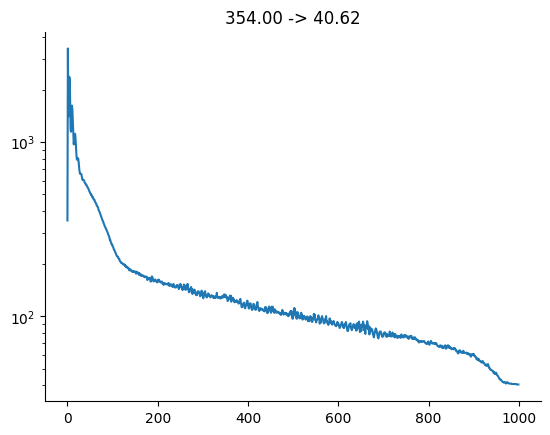

In [3]:
# %%prun
torch.manual_seed(100)
reference = nn.Linear(256, 512, bias=False).cuda().bfloat16()
input = (torch.randn(4096, 32) @ torch.randn(32, 256)).cuda().bfloat16()  # low-rank inputs
with torch.no_grad():
    reference_output = reference(input)

layer = T.Linear(T.Weight(reference.weight, Q.LinearScalingFormat(Q.crd_block_normal(4, 64), Q.BFLOAT16, (1, 64), "absmax"), "dynamic", clip_gradient=True))

steps = 1000

opt = torch.optim.AdamW([
    dict(params=[p for n, p in layer.named_parameters() if n.endswith(".master") or n.endswith(".sparse_weight")], lr=1e-2),
    dict(params=[p for n, p in layer.named_parameters() if n.endswith(".scale")], lr=1e-2),
    dict(params=[p for n, p in layer.named_parameters() if n.endswith(".centroids")], lr=1e-2),
], lr=0, betas=(0.9, 0.9))
schedule = torch.optim.lr_scheduler.LambdaLR(opt, E.qat._lr_schedule_fn("cosine", steps))
# schedule = torch.optim.lr_scheduler.LambdaLR(opt, lambda n: math.exp(math.log(1e-6) * n / steps))
losses = []
for _ in range(steps):
    opt.zero_grad()
    output = layer(input)
    loss = (output - reference_output).pow(2).sum()
    loss.backward()
    opt.step()
    schedule.step()
    losses.append(loss.sqrt().item())

_, ax = plt.subplots()
ax.plot(losses)
ax.set_yscale("log")
ax.set_title(f"{losses[0]:.2f} -> {torch.tensor(losses[-10:]).mean().item():.2f}");